# Create configs:
## Create a list of config files 
1) Create a base config file:
    1) Define the covariates dict `COVARS`
    2) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
3) Iteratively increase or decrease a COV_TO_GEN relation and create multiple variations of the base config file.
    1) Define the number of steps of iteration
    2) Define the increment size
3) Test that the config file meets the expectation using `ToyBrainsData(config=...).show_current_config()`
4) Generate the datasets
5) For all covariates, estimate the maximum predictable accuracy from the generative attributes
    1) using linear/logistic regression model with $R^2$/$D^2$ metric for goodness-of-fit respectively.
    2) using SHAP


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import datasets, linear_model
import random
import math
from copy import copy, deepcopy

# if parent 'Toybrains' directory is not in path, add it
if os.path.abspath('../../') not in sys.path:
    sys.path.append(os.path.abspath('../../'))
from create_toybrains import ToyBrainsData
from utils.vizutils import *
from utils.configutils import *

Define a simple case with 1 binary confound and 1 binary label:

In [7]:
# 1) Create a base config file:
#   a) Define the covariates dict `COVARS`
COVARS = {
            'cov_site'   : dict(states=['siteA', 'siteB']),
            'lbl_lesion' : dict(states=[True, False]),
         }
#   b) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
# Rules about which covariate-state influences which generative variables
RULES_COV_TO_GEN = {
    ## (1) c --> X: `siteA -> brain intensity is higher` 
    'cov_site':{
        'siteA':{ 
            'brain-int_fill'  :  dict(amt=(1,1,1,1,1)),
            ## (2) c --> y: `siteA -> more likely to be lesion group` 
            'lbl_lesion' : dict(idxs=(1),amt=(0))
        },
        'siteB':{
            'brain-int_fill'  : dict(amt=(1,1,1,1,1)),
            ## (2) c --> y: `siteB -> more likely to be control group` 
            'lbl_lesion' : dict(idxs=(0),amt=(0))
        },
    },
    
    ## (3) X --> y: `lbl_lesion is True -> Volume of mid-right lesion is higher`
    'lbl_lesion':{
        True:{  
            'shape-midr_curv'    :dict(amt=(1,1,1,1,1,1,1,1,1)), 
            'shape-midr_vol-rad' :dict(amt=(1,1,1,1))},
        False:{ 
            'shape-midr_curv'    :dict(amt=(1,1,1,1,1,1,1,1,1)),
            'shape-midr_vol-rad' :dict(amt=(1,1,1,1))},
    },
}

In [8]:
basefilename = 'lblmidr-consite'
# create a folder to save all the configs
config_dirname = 'configs/'

if not os.path.exists(config_dirname):
    os.makedirs(config_dirname)

In [ ]:
! rm -rf $config_dirname

Sampling image gen. attributes for n=1000 toybrain samples


100%|██████████| 1000/1000 [00:02<00:00, 405.38it/s]


Config file: configs//lblmidr-consite.py


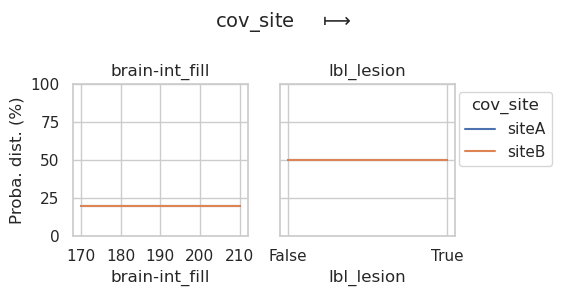

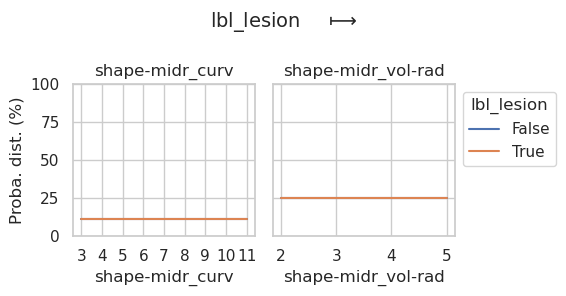

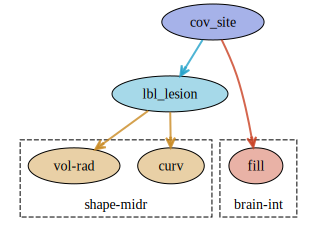

removed 'configs//lblmidr-consite.py'


In [5]:
# first create the base config file
config_fname = f'{config_dirname}/{basefilename}.py'
    
# see the base config file's causal graph
rules = deepcopy(RULES_COV_TO_GEN)
create_config_file(
                config_fname, COVARS, rules, 
                show_dag_probas=True,
                return_baseline_results = False,
                gen_images=0)

!rm -v $config_fname

Now iteratively generate more config files by:
1. incrementally increasing $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in 5 steps from 0% association to 100% association
2. incrementally increasing partial $c_{site} \rightarrow {brain-int\_fill}$ in 5 steps from 0 to 100% 
3. incrementally increasing partial $c_{site} \rightarrow y_{lesion}$ in 5 steps from 0 to 100% 

In [6]:
import math

def gen_yX_weights(arr, mul=1):
    return (np.arange(1, len(arr)+1, 1)*arr*mul).tolist()
    return new_arr

def gen_yX_weights_rev(arr, mul=1):
    return gen_yX_weights(arr[::-1], mul)[::-1]

In [7]:
# (1) incrementally increasing $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in 5 steps 
# from 0% association to 100% association
tweak_rules_yX =[
    ['lbl_lesion', True,   'shape-midr_curv',    'amt', gen_yX_weights],#lambda amt, i: gen_yX_weights(amt, mul=1)],
    ['lbl_lesion', True,   'shape-midr_vol-rad', 'amt', lambda amt: gen_yX_weights(amt, mul=2)],#lambda amt: gen_yX_weights(amt, mul=2)],
    ['lbl_lesion', False,  'shape-midr_curv',    'amt', gen_yX_weights_rev],#lambda amt: gen_yX_weights_rev(amt, mul=1)],
    ['lbl_lesion', False,  'shape-midr_vol-rad', 'amt', lambda amt: gen_yX_weights_rev(amt, mul=2)],#lambda amt: gen_yX_weights_rev(amt, mul=1)],
]
# test
test_tweak_rules(RULES_COV_TO_GEN, tweak_rules_yX, iters=5)

--------------------------------------------------
i=0
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = (1, 1, 1, 1, 1, 1, 1, 1, 1)
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = (1, 1, 1, 1)
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = (1, 1, 1, 1, 1, 1, 1, 1, 1)
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 amt = (1, 1, 1, 1)
--------------------------------------------------
i=1
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = [1, 2, 3, 4, 5, 6, 7, 8, 9]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = [2, 4, 6, 8]
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = [9, 8, 7, 6, 5, 4, 3, 2, 1]
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 amt = [8, 6, 4, 2]
--------------------------------------------------
i=2
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = [1, 4, 9, 16, 25, 36, 49, 64, 81]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = [4, 16, 36, 64]
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = [81, 64, 49, 36, 25, 16, 9, 4, 1]
	 lbl_lesion = False 	--> sh

In [8]:
# (2) incrementally increasing partial $c_{site} --> a_{brain-int_fill}$ in 5 steps from 0 to 100%
tweak_rules_cX =[
    ['cov_site', 'siteA', 'brain-int_fill', 'amt', lambda amt: gen_yX_weights(amt, mul=2)],
    ['cov_site', 'siteB', 'brain-int_fill', 'amt', lambda amt: gen_yX_weights_rev(amt, mul=2)]
]
test_tweak_rules(RULES_COV_TO_GEN, tweak_rules_cX)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> brain-int_fill:	 amt = (1, 1, 1, 1, 1)
	 cov_site = siteB 	--> brain-int_fill:	 amt = (1, 1, 1, 1, 1)
--------------------------------------------------
i=1
	 cov_site = siteA 	--> brain-int_fill:	 amt = [2, 4, 6, 8, 10]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [10, 8, 6, 4, 2]
--------------------------------------------------
i=2
	 cov_site = siteA 	--> brain-int_fill:	 amt = [4, 16, 36, 64, 100]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [100, 64, 36, 16, 4]
--------------------------------------------------
i=3
	 cov_site = siteA 	--> brain-int_fill:	 amt = [8, 64, 216, 512, 1000]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [1000, 512, 216, 64, 8]
--------------------------------------------------
i=4
	 cov_site = siteA 	--> brain-int_fill:	 amt = [16, 256, 1296, 4096, 10000]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [10000, 4096, 1296, 256, 16]


In [9]:
# (3) incrementally increasing partial $c_{site} --> y_{lesion}$ in 5 steps from 0 to 100% 
tweak_rules_cy =[
    ['cov_site', 'siteA', 'lbl_lesion', 'amt', lambda x: int((x+1)**2)],
    ['cov_site', 'siteB', 'lbl_lesion', 'amt', lambda x: int((x+1)**2)]
]
test_tweak_rules(RULES_COV_TO_GEN, tweak_rules_cy)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> lbl_lesion:	 amt = 0
	 cov_site = siteB 	--> lbl_lesion:	 amt = 0
--------------------------------------------------
i=1
	 cov_site = siteA 	--> lbl_lesion:	 amt = 1
	 cov_site = siteB 	--> lbl_lesion:	 amt = 1
--------------------------------------------------
i=2
	 cov_site = siteA 	--> lbl_lesion:	 amt = 4
	 cov_site = siteB 	--> lbl_lesion:	 amt = 4
--------------------------------------------------
i=3
	 cov_site = siteA 	--> lbl_lesion:	 amt = 25
	 cov_site = siteB 	--> lbl_lesion:	 amt = 25
--------------------------------------------------
i=4
	 cov_site = siteA 	--> lbl_lesion:	 amt = 676
	 cov_site = siteB 	--> lbl_lesion:	 amt = 676


In [10]:
# ! rm -rf dataset/toybrains_n*$basefilename*

In [11]:
N_SAMPLES  = 10000
GEN_BASELINES = True
GEN_IMAGES = False

In [12]:
# collect all the rules
all_rules = []
for cy in range(5):
    if cy==0:
        rules_cy = deepcopy(RULES_COV_TO_GEN)
    else:
        rules_cy = apply_tweak_rules(rules_cy, tweak_rules_cy)
    for cX in range(5):
        if cX==0: # reset the rules to previous loop's rules
            rules_cX = deepcopy(rules_cy)
        else:
            rules_cX = apply_tweak_rules(rules_cX, tweak_rules_cX)
        for yX in range(5):
            if yX==0: # reset the rules to previous loop's rules
                rules_yX = deepcopy(rules_cX)
            else:
                rules_yX = apply_tweak_rules(rules_yX, tweak_rules_yX)
            # print(f'cy={cy}, cX={cX}, yX={yX}, {rules_yX["lbl_lesion"][True]["shape-midr_curv"]["amt"]}')
            all_rules.append(((cy, cX, yX), deepcopy(rules_yX)))
            


In [13]:
# parallelize the generation of configs using joblib
from joblib import Parallel, delayed

def create_config_file_parallel(cy,cX,yX, rules):
    config_fname = f'{config_dirname}/{basefilename}_cy{cy}-cX{cX}-yX{yX}.py'
    
    # only generate images for one mid subset of settings to save time
    if GEN_IMAGES==True and cX==2 and yX==2: 
        GEN_IMAGES = True
    else:
        GEN_IMAGES = False
        
    #generate the config file
    bl_result = create_config_file(
                    config_fname, COVARS, rules, 
                    show_dag_probas=False,
                    return_baseline_results=GEN_BASELINES,
                    n_samples=N_SAMPLES,
                    gen_images=GEN_IMAGES)
    return bl_result

bl_results = Parallel(
    n_jobs=30, verbose=10)(
                        delayed(
                            create_config_file_parallel)(
                                cy,cX,yX, r) for ((cy,cX,yX), r) in all_rules)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


Sampling image gen. attributes for n=10000 toybrain samples


  1%|          | 55/10000 [00:00<00:34, 289.48it/s]

Sampling image gen. attributes for n=10000 toybrain samples


  1%|▏         | 147/10000 [00:00<00:24, 399.86it/s]

Sampling image gen. attributes for n=10000 toybrain samples


  3%|▎         | 262/10000 [00:00<00:34, 280.14it/s]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 0/10000 [00:00<?, ?it/s]148.75it/s]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 36/10000 [00:00<01:29, 111.58it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 44/10000 [00:00<02:13, 74.34it/s]s]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  2%|▏         | 226/10000 [00:01<00:36, 265.47it/s]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  4%|▍         | 399/10000 [00:01<00:24, 391.86it/s]]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  7%|▋         | 733/10000 [00:04<00:33, 273.54it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 10/10000 [00:00<01:50, 90.44it/s]]]]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  1%|          | 97/10000 [00:00<00:28, 348.87it/s]]]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  5%|▍         | 461/10000 [00:03<00:37, 252.30it/s]]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 16/10000 [00:00<01:08, 145.73it/s]]]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  9%|▊         | 858/10000 [00:05<01:04, 141.00it/s]]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


 15%|█▌        | 1540/10000 [00:05<00:36, 232.41it/s]

Sampling image gen. attributes for n=10000 toybrain samples


 51%|█████     | 5071/10000 [01:23<01:22, 59.88it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX0_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX0_yX2


 98%|█████████▊| 9840/10000 [01:31<00:03, 41.22it/s]

Generating n=10000 toybrain images


  0%|          | 0/50 [00:00<?, ?it/s]35, 49.27it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX4_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX4_yX0


 60%|██████    | 6030/10000 [01:33<02:03, 32.26it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX4_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX4_yX1


 51%|█████     | 5088/10000 [01:29<02:35, 31.54it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX4_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX4_yX2


 54%|█████▍    | 5379/10000 [01:31<03:44, 20.62it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX1_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX1_yX2
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX2_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX2_yX4


 57%|█████▋    | 5694/10000 [01:41<03:12, 22.39it/s] 

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX1_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX1_yX3


 64%|██████▍   | 6448/10000 [02:10<01:40, 35.40it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX3_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX3_yX2


 68%|██████▊   | 6764/10000 [02:18<00:52, 61.08it/s]

TOTAL RUNTIME: 0:00:50


 67%|██████▋   | 6749/10000 [02:13<01:38, 32.86it/s]

Sampling image gen. attributes for n=10000 toybrain samples


 67%|██████▋   | 6689/10000 [02:15<01:05, 50.25it/s]

TOTAL RUNTIME: 0:00:46


  0%|          | 0/10000 [00:00<?, ?it/s] 41.00it/s]

Sampling image gen. attributes for n=10000 toybrain samples


 65%|██████▌   | 6541/10000 [02:17<01:47, 32.24it/s]

TOTAL RUNTIME: 0:00:48


 65%|██████▌   | 6535/10000 [02:17<01:34, 36.63it/s]

Sampling image gen. attributes for n=10000 toybrain samples


 72%|███████▏  | 7170/10000 [02:24<01:29, 31.52it/s]]

TOTAL RUNTIME: 0:00:50


 72%|███████▏  | 7162/10000 [02:20<01:03, 44.97it/s]]

TOTAL RUNTIME: 0:00:48


 70%|██████▉   | 6957/10000 [02:22<00:45, 67.54it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX3_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX3_yX3
Sampling image gen. attributes for n=10000 toybrain samples


 67%|██████▋   | 6707/10000 [02:21<01:35, 34.46it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 68%|██████▊   | 6787/10000 [02:23<01:10, 45.30it/s]]

TOTAL RUNTIME: 0:00:51


 70%|███████   | 7027/10000 [02:23<01:38, 30.28it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 11%|█         | 1100/10000 [00:59<06:01, 24.63it/s]]

TOTAL RUNTIME: 0:00:49


 69%|██████▊   | 6856/10000 [02:26<01:12, 43.50it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 61%|██████    | 6087/10000 [00:30<00:27, 140.14it/s]

TOTAL RUNTIME: 0:00:45


 86%|████████▌ | 8571/10000 [03:00<00:29, 48.31it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 83%|████████▎ | 8308/10000 [03:01<00:39, 42.56it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX0_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX0_yX1


 79%|███████▉  | 7921/10000 [00:45<00:17, 115.71it/s]

TOTAL RUNTIME: 0:00:50


 90%|████████▉ | 8970/10000 [03:11<00:25, 39.99it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 51%|█████     | 5101/10000 [01:03<01:01, 79.06it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX1_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX1_yX1


 96%|█████████▌| 9593/10000 [03:30<00:12, 31.73it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX1_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX1_yX3


 92%|█████████▏| 9248/10000 [03:25<00:20, 36.24it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX2_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX2_yX0


 97%|█████████▋| 9710/10000 [03:30<00:11, 25.26it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX2_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX2_yX0
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX2_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX2_yX1


 53%|█████▎    | 5297/10000 [01:15<02:17, 34.23it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX0_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX0_yX0


 28%|██▊       | 2810/10000 [02:13<07:15, 16.50it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX4_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX4_yX4


 96%|█████████▋| 9640/10000 [03:41<00:19, 18.51it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX1_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX1_yX0


  0%|          | 0/50 [00:00<?, ?it/s]04, 18.53it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX0_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX0_yX1


 97%|█████████▋| 9682/10000 [03:43<00:17, 17.93it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX0_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX0_yX4


100%|█████████▉| 9986/10000 [03:46<00:00, 16.90it/s]]

TOTAL RUNTIME: 0:00:45


 99%|█████████▊| 9866/10000 [03:47<00:08, 15.35it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 57%|█████▋    | 5656/10000 [01:27<02:48, 25.79it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX3_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX3_yX4


 99%|█████████▉| 9921/10000 [03:51<00:04, 16.91it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX0_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX0_yX4


 77%|███████▋  | 7720/10000 [00:40<00:22, 101.28it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX1_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX1_yX4


 99%|█████████▉| 9896/10000 [03:58<00:06, 15.09it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX0_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX0_yX3


 99%|█████████▉| 9929/10000 [03:58<00:05, 13.58it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX3_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX3_yX0


  0%|          | 0/50 [00:00<?, ?it/s]30, 17.44it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX0_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX0_yX3


 97%|█████████▋| 9657/10000 [01:42<00:34, 10.01it/s] 

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX3_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX3_yX1


  0%|          | 0/10000 [00:00<?, ?it/s]  8.21it/s]]

TOTAL RUNTIME: 0:00:45
Sampling image gen. attributes for n=10000 toybrain samples


 97%|█████████▋| 9718/10000 [01:50<00:33,  8.33it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX0_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX0_yX2


 97%|█████████▋| 9722/10000 [01:50<00:30,  8.99it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX0_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX0_yX0


 25%|██▌       | 2517/10000 [00:22<02:15, 55.34it/s]]

TOTAL RUNTIME: 0:00:43


 66%|██████▌   | 6619/10000 [01:56<04:46, 11.82it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


  1%|▏         | 145/10000 [00:01<01:04, 151.68it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX1_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX1_yX1


 99%|█████████▉| 9925/10000 [04:11<00:04, 15.14it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX2_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX2_yX1


 25%|██▍       | 2480/10000 [00:10<01:49, 68.55it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX4_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX4_yX3


100%|█████████▉| 9955/10000 [04:14<00:06,  6.96it/s]]

TOTAL RUNTIME: 0:00:45
TOTAL RUNTIME: 0:00:45
Sampling image gen. attributes for n=10000 toybrain samples
TOTAL RUNTIME: 0:00:51
Sampling image gen. attributes for n=10000 toybrain samples


 98%|█████████▊| 9801/10000 [01:58<00:14, 13.86it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


  2%|▏         | 165/10000 [00:04<05:56, 27.56it/s]]]

TOTAL RUNTIME: 0:00:43


  0%|          | 0/10000 [00:00<?, ?it/s] 25.81it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX2_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX2_yX3
Sampling image gen. attributes for n=10000 toybrain samples


 47%|████▋     | 4726/10000 [01:30<06:12, 14.16it/s]]

TOTAL RUNTIME: 0:00:44


 99%|█████████▉| 9906/10000 [02:09<00:08, 10.76it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 21%|██        | 2092/10000 [00:14<01:23, 94.94it/s] 

TOTAL RUNTIME: 0:00:48


  3%|▎         | 284/10000 [00:08<04:15, 38.09it/s]]]

TOTAL RUNTIME: 0:00:51


 22%|██▏       | 2225/10000 [00:16<02:03, 63.17it/s] 

TOTAL RUNTIME: 0:00:49
Sampling image gen. attributes for n=10000 toybrain samples


  4%|▎         | 364/10000 [00:10<03:47, 42.38it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 23%|██▎       | 2306/10000 [00:18<01:22, 93.74it/s]

Sampling image gen. attributes for n=10000 toybrain samples


  8%|▊         | 807/10000 [00:19<05:14, 29.21it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX1_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX1_yX2


 46%|████▋     | 4645/10000 [00:50<05:35, 15.95it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX2_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX2_yX3
TOTAL RUNTIME: 0:00:48


 10%|█         | 1000/10000 [00:24<04:52, 30.79it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 10%|▉         | 982/10000 [00:24<03:22, 44.58it/s]]]

TOTAL RUNTIME: 0:00:49


  0%|          | 4/10000 [00:00<05:37, 29.65it/s]/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 25%|██▍       | 2494/10000 [00:32<04:34, 27.36it/s]]

TOTAL RUNTIME: 0:00:51


  4%|▍         | 410/10000 [00:09<03:12, 49.86it/s]]]

Sampling image gen. attributes for n=10000 toybrain samples


  5%|▌         | 522/10000 [00:10<02:19, 68.15it/s]] 

TOTAL RUNTIME: 0:00:46


 26%|██▌       | 2606/10000 [00:35<03:12, 38.39it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


  6%|▋         | 645/10000 [00:13<02:40, 58.14it/s]]]

TOTAL RUNTIME: 0:00:46


 26%|██▋       | 2645/10000 [00:36<02:20, 52.49it/s]]

TOTAL RUNTIME: 0:00:47


 66%|██████▌   | 6607/10000 [02:25<02:31, 22.38it/s] 

Sampling image gen. attributes for n=10000 toybrain samples


  5%|▌         | 502/10000 [00:07<01:51, 85.32it/s]s]

Sampling image gen. attributes for n=10000 toybrain samples


  9%|▉         | 883/10000 [00:16<02:07, 71.61it/s]]]

TOTAL RUNTIME: 0:00:50


  9%|▉         | 902/10000 [00:06<02:29, 60.89it/s]]]

Sampling image gen. attributes for n=10000 toybrain samples


 34%|███▎      | 3366/10000 [00:37<03:12, 34.39it/s]]

TOTAL RUNTIME: 0:00:45


 34%|███▍      | 3389/10000 [00:37<02:22, 46.52it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 34%|███▍      | 3417/10000 [00:38<01:45, 62.38it/s]]

TOTAL RUNTIME: 0:00:46


 53%|█████▎    | 5294/10000 [00:27<00:23, 196.50it/s]

TOTAL RUNTIME: 0:00:42


 54%|█████▍    | 5377/10000 [00:28<00:22, 202.93it/s]

Sampling image gen. attributes for n=10000 toybrain samples


 69%|██████▊   | 6856/10000 [02:34<01:45, 29.93it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 15%|█▍        | 1456/10000 [00:18<02:10, 65.71it/s]]

TOTAL RUNTIME: 0:00:49


 55%|█████▍    | 5475/10000 [01:15<01:20, 56.48it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 26%|██▌       | 2581/10000 [00:48<01:46, 69.69it/s]]

TOTAL RUNTIME: 0:00:51


 18%|█▊        | 1761/10000 [00:19<01:25, 96.43it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 30%|██▉       | 2978/10000 [00:50<01:51, 63.22it/s]]

TOTAL RUNTIME: 0:00:50


 26%|██▌       | 2573/10000 [00:33<01:54, 64.79it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 44%|████▍     | 4403/10000 [00:25<00:28, 193.01it/s]

TOTAL RUNTIME: 0:00:43
Sampling image gen. attributes for n=10000 toybrain samples


 51%|█████▏    | 5131/10000 [01:16<01:09, 69.58it/s]]

TOTAL RUNTIME: 0:00:49
Sampling image gen. attributes for n=10000 toybrain samples


 33%|███▎      | 3273/10000 [00:40<01:22, 81.92it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX4_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX4_yX1


 64%|██████▎   | 6358/10000 [01:33<01:13, 49.81it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX0_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX0_yX2


 69%|██████▉   | 6912/10000 [01:52<01:11, 43.46it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX1_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX1_yX2


 56%|█████▌    | 5551/10000 [01:15<01:25, 51.78it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX1_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX1_yX0


 60%|██████    | 6015/10000 [01:37<01:32, 43.25it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX2_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX2_yX1


 61%|██████    | 6093/10000 [01:39<01:48, 36.05it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 64%|██████▎   | 6354/10000 [01:46<01:48, 33.58it/s]]

Generating n=10000 toybrain images


 76%|███████▌  | 7605/10000 [02:10<01:14, 32.36it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX1_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX1_yX4


 70%|██████▉   | 6980/10000 [02:15<01:43, 29.16it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX2_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX2_yX4


 64%|██████▎   | 6372/10000 [01:42<01:54, 31.80it/s]]

TOTAL RUNTIME: 0:00:48
Sampling image gen. attributes for n=10000 toybrain samples


 69%|██████▉   | 6939/10000 [01:53<01:53, 26.93it/s]]

TOTAL RUNTIME: 0:00:42
Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 38/10000 [00:00<00:26, 373.74it/s]]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 77%|███████▋  | 7694/10000 [02:32<01:27, 26.48it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 73%|███████▎  | 7259/10000 [02:02<01:31, 29.98it/s]]

Generating n=10000 toybrain images


 87%|████████▋ | 8734/10000 [02:50<00:44, 28.38it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX2_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX2_yX4


  0%|          | 0/50 [00:00<?, ?it/s]57, 35.30it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX3_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX3_yX0


 66%|██████▌   | 6596/10000 [01:47<01:57, 29.04it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX3_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX3_yX0


 10%|█         | 1010/10000 [00:47<07:20, 20.40it/s]]

TOTAL RUNTIME: 0:00:45
Sampling image gen. attributes for n=10000 toybrain samples


 70%|███████   | 7047/10000 [02:01<01:09, 42.24it/s]]

TOTAL RUNTIME: 0:00:49
Sampling image gen. attributes for n=10000 toybrain samples


 91%|█████████ | 9084/10000 [02:55<00:34, 26.80it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX3_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX3_yX1


 94%|█████████▍| 9448/10000 [03:09<00:19, 28.99it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX3_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX3_yX3


 93%|█████████▎| 9287/10000 [03:24<00:34, 20.61it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 11%|█         | 1070/10000 [00:52<07:21, 20.21it/s]]

TOTAL RUNTIME: 0:00:48
Sampling image gen. attributes for n=10000 toybrain samples


 93%|█████████▎| 9280/10000 [03:08<00:22, 32.04it/s]]

TOTAL RUNTIME: 0:00:45
Sampling image gen. attributes for n=10000 toybrain samples


 82%|████████▏ | 8187/10000 [02:34<00:37, 48.05it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX3_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX3_yX4


100%|█████████▉| 9993/10000 [03:49<00:00, 35.81it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX4_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX4_yX4


 99%|█████████▉| 9880/10000 [03:50<00:04, 26.29it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX0_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX0_yX0


 95%|█████████▌| 9520/10000 [03:33<00:18, 25.65it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX3_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX3_yX4


 17%|█▋        | 1742/10000 [00:19<02:06, 65.13it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX3_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX3_yX2


 36%|███▋      | 3637/10000 [00:52<03:35, 29.53it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX3_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX3_yX1


 97%|█████████▋| 9657/10000 [03:41<00:23, 14.37it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX4_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX4_yX2


 20%|██        | 2015/10000 [00:26<03:28, 38.25it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX0_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX0_yX3


 96%|█████████▌| 9580/10000 [03:30<00:39, 10.62it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX3_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX3_yX3


 94%|█████████▍| 9387/10000 [03:16<00:49, 12.45it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX4_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX4_yX0


  0%|          | 0/10000 [00:00<?, ?it/s] 11.99it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 39%|███▉      | 3949/10000 [01:08<07:03, 14.29it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX0_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX0_yX1


 96%|█████████▌| 9587/10000 [03:35<00:58,  7.11it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX0_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX0_yX4


 41%|████      | 4082/10000 [01:15<04:24, 22.36it/s]]

TOTAL RUNTIME: 0:00:51
Sampling image gen. attributes for n=10000 toybrain samples


 99%|█████████▊| 9859/10000 [03:51<00:14,  9.70it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX4_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX4_yX3


 42%|████▏     | 4239/10000 [01:22<06:10, 15.55it/s]

TOTAL RUNTIME: 0:00:48
Sampling image gen. attributes for n=10000 toybrain samples


 96%|█████████▌| 9570/10000 [07:24<00:24, 17.87it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX4_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX4_yX3


 98%|█████████▊| 9754/10000 [03:52<00:15, 15.96it/s]]

TOTAL RUNTIME: 0:00:49
Sampling image gen. attributes for n=10000 toybrain samples
TOTAL RUNTIME: 0:00:48
TOTAL RUNTIME: 0:00:49


  0%|          | 4/10000 [00:00<04:13, 39.46it/s]/s]]

Sampling image gen. attributes for n=10000 toybrain samples
Sampling image gen. attributes for n=10000 toybrain samples


  1%|          | 123/10000 [00:02<03:06, 52.96it/s]s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX1_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX1_yX1


 49%|████▉     | 4885/10000 [00:16<00:20, 250.26it/s]

TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX1_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX1_yX3


 54%|█████▍    | 5375/10000 [00:18<00:22, 208.99it/s]

TOTAL RUNTIME: 0:00:48
Sampling image gen. attributes for n=10000 toybrain samples


 61%|██████    | 6091/10000 [02:13<02:38, 24.65it/s] 

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX1_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX1_yX0


  0%|          | 0/10000 [00:00<?, ?it/s]43.82it/s]]]

TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples


 31%|███       | 3105/10000 [01:11<04:03, 28.35it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 99%|█████████▉| 9904/10000 [04:04<00:11,  8.65it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX1_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX1_yX4


 35%|███▍      | 3463/10000 [01:21<02:37, 41.59it/s]]

TOTAL RUNTIME: 0:00:49
Sampling image gen. attributes for n=10000 toybrain samples


  3%|▎         | 283/10000 [00:06<03:35, 45.04it/s]]]

TOTAL RUNTIME: 0:00:51
Sampling image gen. attributes for n=10000 toybrain samples


  6%|▌         | 561/10000 [00:12<02:28, 63.46it/s]]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy0_cX2_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy0_cX2_yX2


 36%|███▋      | 3634/10000 [01:27<04:42, 22.54it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 55%|█████▌    | 5514/10000 [02:08<04:17, 17.42it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX2_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX2_yX0


  0%|          | 0/10000 [00:00<?, ?it/s] 41.25it/s]]

TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples


 16%|█▌        | 1576/10000 [00:33<02:26, 57.47it/s]]

TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples


 13%|█▎        | 1265/10000 [00:25<02:37, 55.30it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX0_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX0_yX2


 21%|██        | 2058/10000 [00:41<02:54, 45.43it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 18%|█▊        | 1770/10000 [00:40<03:17, 41.74it/s]]

TOTAL RUNTIME: 0:00:41
Sampling image gen. attributes for n=10000 toybrain samples


  3%|▎         | 280/10000 [00:03<01:31, 105.68it/s]]

TOTAL RUNTIME: 0:00:41
Sampling image gen. attributes for n=10000 toybrain samples


  4%|▍         | 400/10000 [00:05<01:54, 83.96it/s]]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 70%|███████   | 7046/10000 [02:58<01:28, 33.38it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX2_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX2_yX3


 35%|███▌      | 3511/10000 [01:23<01:21, 79.77it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 38%|███▊      | 3847/10000 [01:27<00:39, 157.25it/s]

TOTAL RUNTIME: 0:00:40
Sampling image gen. attributes for n=10000 toybrain samples


  4%|▎         | 353/10000 [00:03<01:45, 91.03it/s] ]

TOTAL RUNTIME: 0:00:44


 28%|██▊       | 2845/10000 [00:50<01:54, 62.55it/s]]

Sampling image gen. attributes for n=10000 toybrain samples


 16%|█▋        | 1630/10000 [00:17<01:37, 86.11it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX1_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX1_yX2


 41%|████      | 4053/10000 [01:08<01:35, 62.49it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 76%|███████▋  | 7636/10000 [03:14<01:00, 38.88it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX2_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX2_yX4


 80%|████████  | 8000/10000 [03:25<01:02, 32.18it/s]]

TOTAL RUNTIME: 0:00:45
Sampling image gen. attributes for n=10000 toybrain samples


 56%|█████▌    | 5587/10000 [01:37<01:33, 47.20it/s]]

TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples


 75%|███████▍  | 7472/10000 [00:34<00:16, 153.79it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX4_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX4_yX1


 80%|███████▉  | 7968/10000 [03:16<00:54, 37.51it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 67%|██████▋   | 6692/10000 [02:10<01:19, 41.84it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX4_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX4_yX2


 70%|██████▉   | 6969/10000 [02:18<01:09, 43.85it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX3_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX3_yX2


 79%|███████▊  | 7851/10000 [02:58<01:07, 31.66it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX4_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX4_yX0


 79%|███████▉  | 7925/10000 [02:43<01:00, 34.08it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 66%|██████▌   | 6601/10000 [01:46<01:48, 31.35it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX4_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX4_yX4


 80%|███████▉  | 7968/10000 [02:47<01:12, 28.13it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX4_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX4_yX1


 94%|█████████▍| 9432/10000 [04:10<00:27, 20.33it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 75%|███████▍  | 7478/10000 [02:16<01:35, 26.36it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX0_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX0_yX0


 84%|████████▍ | 8419/10000 [03:05<00:53, 29.52it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 61%|██████▏   | 6134/10000 [01:44<01:54, 33.82it/s]]

TOTAL RUNTIME: 0:00:43
Sampling image gen. attributes for n=10000 toybrain samples


 78%|███████▊  | 7849/10000 [02:27<01:16, 28.00it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX4_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX4_yX2


 95%|█████████▍| 9469/10000 [03:51<00:24, 21.48it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX1_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX1_yX1


 79%|███████▉  | 7908/10000 [02:29<01:16, 27.37it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX4_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX4_yX4


 83%|████████▎ | 8301/10000 [02:48<01:44, 16.30it/s]]

TOTAL RUNTIME: 0:00:49
Sampling image gen. attributes for n=10000 toybrain samples


 97%|█████████▋| 9728/10000 [04:04<00:12, 22.40it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX0_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX0_yX1


 85%|████████▌ | 8511/10000 [02:58<00:53, 27.99it/s]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


 94%|█████████▍| 9430/10000 [03:46<00:21, 26.91it/s]]

TOTAL RUNTIME: 0:00:42
Sampling image gen. attributes for n=10000 toybrain samples


 93%|█████████▎| 9334/10000 [03:36<00:31, 21.48it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX0_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX0_yX0


 92%|█████████▏| 9245/10000 [03:31<00:29, 25.54it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX0_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX0_yX2


 97%|█████████▋| 9702/10000 [03:58<00:14, 20.30it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX0_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX0_yX1


 91%|█████████ | 9120/10000 [03:25<00:35, 25.03it/s]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 40%|████      | 20/50 [00:18<00:32,  1.08s/it]it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 99%|█████████▉| 9941/10000 [04:11<00:03, 19.28it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX0_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX0_yX4
TOTAL RUNTIME: 0:00:45
Sampling image gen. attributes for n=10000 toybrain samples


  3%|▎         | 299/10000 [00:02<01:23, 115.63it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX0_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX0_yX3


  0%|          | 0/50 [00:00<?, ?it/s]07, 15.47it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX1_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX1_yX0


 93%|█████████▎| 9297/10000 [03:33<00:34, 20.42it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


100%|█████████▉| 9987/10000 [04:02<00:00, 22.23it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX2_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX2_yX0
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX1_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX1_yX4


  7%|▋         | 739/10000 [00:11<02:43, 56.58it/s]]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX1_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX1_yX3
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX2_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX2_yX1


 93%|█████████▎| 9344/10000 [03:36<00:41, 15.97it/s]]

Generating n=10000 toybrain images


 95%|█████████▍| 9481/10000 [03:47<00:29, 17.59it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX1_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX1_yX0
TOTAL RUNTIME: 0:00:43
Sampling image gen. attributes for n=10000 toybrain samples


 18%|█▊        | 1755/10000 [00:31<04:03, 33.90it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX2_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX2_yX3


 19%|█▉        | 1885/10000 [00:34<03:31, 38.42it/s]]

TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples


 97%|█████████▋| 9708/10000 [03:59<00:26, 11.10it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX1_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX1_yX2


 22%|██▏       | 2165/10000 [00:44<03:17, 39.72it/s]]

TOTAL RUNTIME: 0:00:45
Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 0/10000 [00:00<?, ?it/s] 16.59it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


  1%|▏         | 131/10000 [00:01<02:15, 72.79it/s]]]

TOTAL RUNTIME: 0:00:42
Sampling image gen. attributes for n=10000 toybrain samples


 21%|██        | 2060/10000 [00:46<02:32, 51.99it/s]]

TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples


 25%|██▍       | 2463/10000 [00:55<02:32, 49.47it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX3_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX3_yX0


 27%|██▋       | 2684/10000 [00:57<01:31, 79.70it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX3_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX3_yX1


 25%|██▌       | 2544/10000 [00:56<03:17, 37.81it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


  2%|▏         | 166/10000 [00:02<01:54, 86.01it/s]]]

TOTAL RUNTIME: 0:00:46
Sampling image gen. attributes for n=10000 toybrain samples


  0%|          | 0/10000 [00:00<?, ?it/s] 42.42it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX3_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX3_yX3
TOTAL RUNTIME: 0:00:47
Sampling image gen. attributes for n=10000 toybrain samples


 15%|█▍        | 1462/10000 [00:18<02:34, 55.26it/s]

TOTAL RUNTIME: 0:00:48
Sampling image gen. attributes for n=10000 toybrain samples


 20%|█▉        | 1957/10000 [00:38<02:54, 46.18it/s] 

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX3_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX3_yX2


  4%|▎         | 355/10000 [00:03<02:24, 66.63it/s]]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX4_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX4_yX0
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX3_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX3_yX4


 51%|█████▏    | 5149/10000 [02:01<05:01, 16.11it/s]]

TOTAL RUNTIME: 0:00:48
Sampling image gen. attributes for n=10000 toybrain samples


 10%|▉         | 978/10000 [00:12<02:54, 51.57it/s]]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX2_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX2_yX1


 17%|█▋        | 1673/10000 [00:26<03:58, 34.88it/s]]

TOTAL RUNTIME: 0:00:44
Sampling image gen. attributes for n=10000 toybrain samples


 35%|███▍      | 3478/10000 [01:21<03:00, 36.08it/s]]

TOTAL RUNTIME: 0:00:49
Sampling image gen. attributes for n=10000 toybrain samples


 17%|█▋        | 1722/10000 [00:33<02:21, 58.64it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX2_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX2_yX3


 14%|█▍        | 1417/10000 [00:23<02:27, 58.38it/s]]

TOTAL RUNTIME: 0:00:42


 93%|█████████▎| 9309/10000 [04:11<00:32, 20.96it/s]]

TOTAL RUNTIME: 0:00:44


 33%|███▎      | 3284/10000 [00:59<01:39, 67.64it/s]]

TOTAL RUNTIME: 0:00:42
TOTAL RUNTIME: 0:00:45


 61%|██████    | 6087/10000 [02:35<01:28, 44.13it/s]]

TOTAL RUNTIME: 0:00:41


 34%|███▍      | 3408/10000 [01:03<01:33, 70.28it/s]]

TOTAL RUNTIME: 0:00:46


 41%|████      | 4097/10000 [01:27<01:20, 73.20it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy2_cX2_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy2_cX2_yX2


 50%|████▉     | 4970/10000 [02:00<01:05, 77.15it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy3_cX4_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy3_cX4_yX3


 74%|███████▍  | 7432/10000 [03:06<01:08, 37.57it/s]]

TOTAL RUNTIME: 0:00:47


 71%|███████   | 7089/10000 [02:38<01:08, 42.40it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX4_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX4_yX0


 46%|████▌     | 4561/10000 [01:11<01:41, 53.49it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX4_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX4_yX2


 64%|██████▍   | 6446/10000 [00:57<01:22, 43.26it/s] 

TOTAL RUNTIME: 0:00:49


 70%|██████▉   | 6990/10000 [02:36<00:32, 91.31it/s] 

TOTAL RUNTIME: 0:00:42


 75%|███████▍  | 7459/10000 [02:42<00:21, 117.60it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy1_cX2_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy1_cX2_yX2


 67%|██████▋   | 6669/10000 [01:56<01:04, 51.63it/s]]

TOTAL RUNTIME: 0:00:45


 89%|████████▉ | 8946/10000 [02:54<00:09, 112.19it/s]

TOTAL RUNTIME: 0:00:42


 74%|███████▍  | 7450/10000 [02:07<00:42, 60.54it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX0_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX0_yX3


 81%|████████▏ | 8135/10000 [02:15<00:23, 79.62it/s]]

TOTAL RUNTIME: 0:00:49


 74%|███████▍  | 7379/10000 [01:49<00:36, 72.00it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX1_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX1_yX4


 84%|████████▎ | 8351/10000 [02:08<00:13, 117.96it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX2_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX2_yX4


 80%|███████▉  | 7977/10000 [02:05<00:28, 70.15it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX0_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX0_yX4


 91%|█████████▏| 9136/10000 [03:14<00:17, 49.05it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX1_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX1_yX1


 97%|█████████▋| 9651/10000 [01:56<00:06, 52.21it/s]]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX3_yX2
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX3_yX2


  0%|          | 0/50 [00:00<?, ?it/s]40, 41.44it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX3_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX3_yX3


 94%|█████████▍| 9440/10000 [02:40<00:16, 34.00it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX4_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX4_yX4


 90%|█████████ | 9025/10000 [02:26<00:24, 39.16it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX2_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX2_yX0


 89%|████████▉ | 8878/10000 [02:29<00:22, 48.99it/s]

TOTAL RUNTIME: 0:00:47


 20%|██        | 10/50 [00:00<00:00, 72.56it/s]it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX1_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX1_yX3


 97%|█████████▋| 9722/10000 [02:51<00:05, 47.08it/s]

Generating n=10000 toybrain images


  0%|          | 0/50 [00:00<?, ?it/s]23, 32.89it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX3_yX0
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX3_yX0


 95%|█████████▍| 9488/10000 [02:44<00:12, 40.98it/s]

TOTAL RUNTIME: 0:00:48


  0%|          | 0/50 [00:00<?, ?it/s]09, 36.59it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX3_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX3_yX1


  2%|▏         | 220/10000 [00:12<08:50, 18.44it/s]]

TOTAL RUNTIME: 0:00:45
TOTAL RUNTIME: 0:00:48


 97%|█████████▋| 9729/10000 [02:40<00:04, 55.86it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX4_yX1
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX4_yX1


100%|█████████▉| 9994/10000 [02:55<00:00, 58.45it/s]

TOTAL RUNTIME: 0:00:49


  0%|          | 0/50 [00:00<?, ?it/s]01, 99.37it/s]

--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX3_yX4
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX3_yX4


100%|██████████| 10000/10000 [02:43<00:00, 61.21it/s]


TOTAL RUNTIME: 0:00:45
--------------------------------------------------
Estimating baseline contrib scores on dataset: toybrains_n10000_lblmidr-consite_cy4_cX4_yX3
 ... running a total of 50 different settings of [input] x [output] x [CV] and saving the result at dataset/toybrains_n10000_lblmidr-consite_cy4_cX4_yX3


  5%|▍         | 460/10000 [00:25<08:28, 18.75it/s]]

TOTAL RUNTIME: 0:00:45


 43%|████▎     | 4330/10000 [03:55<04:22, 21.57it/s]

TOTAL RUNTIME: 0:00:48


 44%|████▎     | 4370/10000 [03:57<04:18, 21.82it/s]

TOTAL RUNTIME: 0:00:44


 45%|████▍     | 4480/10000 [04:02<04:06, 22.42it/s]

TOTAL RUNTIME: 0:00:48


 46%|████▌     | 4560/10000 [04:05<04:00, 22.58it/s][Parallel(n_jobs=30)]: Done 118 out of 125 | elapsed: 17.8min remaining:  1.1min


TOTAL RUNTIME: 0:00:46


 47%|████▋     | 4720/10000 [04:13<03:57, 22.25it/s]

TOTAL RUNTIME: 0:00:45


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]it/s]


TOTAL RUNTIME: 0:00:44


 50%|████▉     | 4980/10000 [04:24<03:45, 22.29it/s]

TOTAL RUNTIME: 0:00:44


 50%|█████     | 5010/10000 [04:25<03:45, 22.16it/s]

TOTAL RUNTIME: 0:00:44


 50%|█████     | 5040/10000 [04:27<03:55, 21.04it/s]

TOTAL RUNTIME: 0:00:43


 58%|█████▊    | 5770/10000 [04:48<03:16, 21.57it/s]

In [9]:
# load the baseline results
bl_results = []
for results_file in glob(f'dataset/*{basefilename}*/baseline_results/run.csv'):
    df = pd.read_csv(results_file)
    bl_results.append(df)

In [10]:
# show_contrib_table(bl_results)

In [57]:
import operator
from difflib import SequenceMatcher

def get_common_substring(names):
    substring_counts={}

    for i in range(0, len(names)):
        for j in range(i+1,len(names)):
            string1 = names[i]
            string2 = names[j]
            match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))
            matching_substring=string1[match.a:match.a+match.size]
            if(matching_substring not in substring_counts):
                substring_counts[matching_substring]=1
            else:
                substring_counts[matching_substring]+=1
                import operator
    max_occurring_substring=max(substring_counts.items(), key=operator.itemgetter(1))[0]
    return max_occurring_substring


def viz_contrib_table(data, X_axes=['X->y','c->X','c->y'], show_SHAP=False):
    for rel in X_axes:
        assert rel in ['X->y','c->X','c->y'], f"invalid rel {rel}"
        
    sns.set(style="darkgrid")
    if isinstance(data, pd.io.formats.style.Styler):
        data = data.data
    df = data.copy().reset_index()
    dataset_prefix = get_common_substring(df.sample(10)['dataset'].values.tolist())
    df['dataset'] = df['dataset'].apply(lambda x: x.replace(dataset_prefix[:-2],''))
    # get the iterations of yX, cX, and cy as separate columns
    df[['c->y','c->X','X->y']] = df['dataset'].str.split('_', expand=True)
    for col in ['X->y','c->X','c->y']:
        # print(col, df[col].values[0])
        df[col] = df[col].str[2:].astype(int)

    # rename the test_metric column to 'Model pred. contrib score'
    y='Model pred. contrib score'
    df = df.rename(columns={'test_metric':y})
    
    col = 'inp'
    col_order = ['attr_all', 'attr_shape-midr_curv, shape-midr_vol-rad', 
                 'attr_brain-int_fill', 'cov_all']
    if show_SHAP:
        y = 'SHAP contrib score'
        col = 'SHAP(attr)'
        col_order = df.filter(regex='shap__').columns.tolist()
        # select only the 'inp'=attr_all rows
        df = df[df['inp']=='attr_all']
        # stack the SHAP cols into a single column 'SHAP' for compatibility with seaborn relplot
        df = df.melt(id_vars=['dataset','inp','c->y','c->X','X->y'], 
                        value_vars=col_order, 
                    var_name=col, value_name=y)
    # display(df)
    for x in X_axes:
        if x=='X->y':
            hue='c->X'
            size='c->y'
        elif x=='c->X':
            hue='X->y'
            size='c->y'
        elif x=='c->y':
            hue='X->y'
            size='c->X'
        else:
            assert False, f"invalid col {x}"

        
        g = sns.relplot(data=df, kind='line', 
                x=x,y=y, hue=hue, style=size, size=size,
                err_style='bars',
                # hue='inp', height=30, aspect=0.5,
                col_wrap=2, col=col, palette='brg_r',
                col_order=col_order,
                height=5, aspect=1.5,
            )
        # turn on frame of the legend
        g._legend.set_frame_on(True)
        # set y lim to 0-100
        g.set(ylim=(0, 100))
        g.fig.suptitle(f"{y} as we iteratively increase {x}", fontsize=20)
        g.fig.subplots_adjust(top=0.9)
        plt.show()

All results are shown in percentage (%)


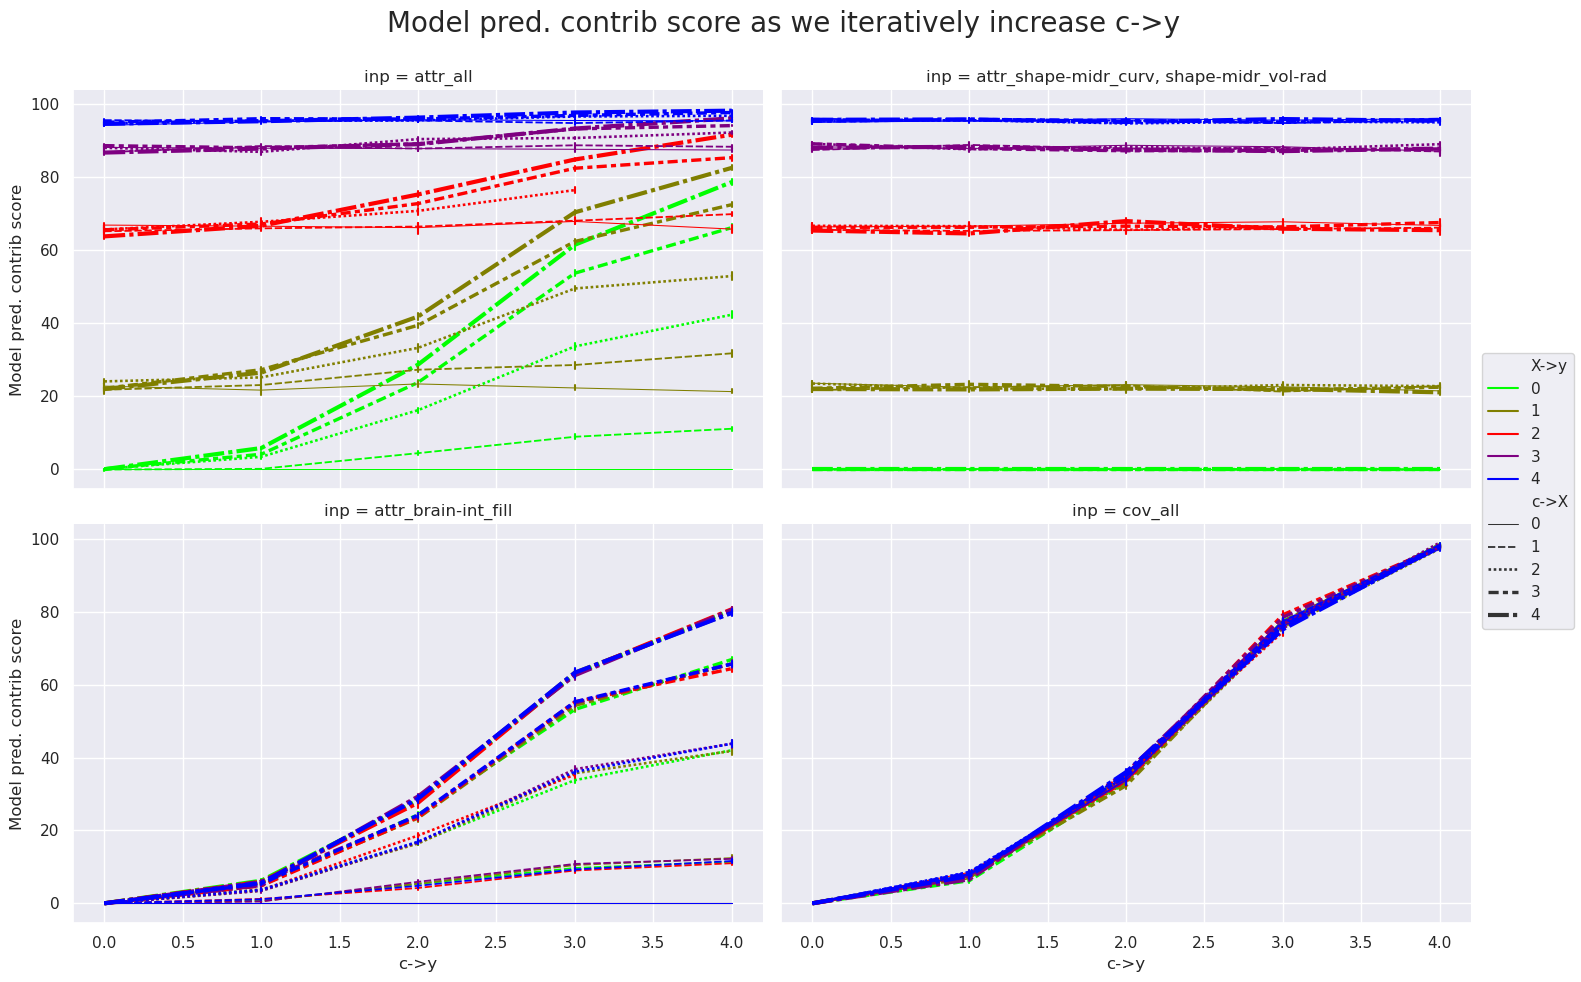

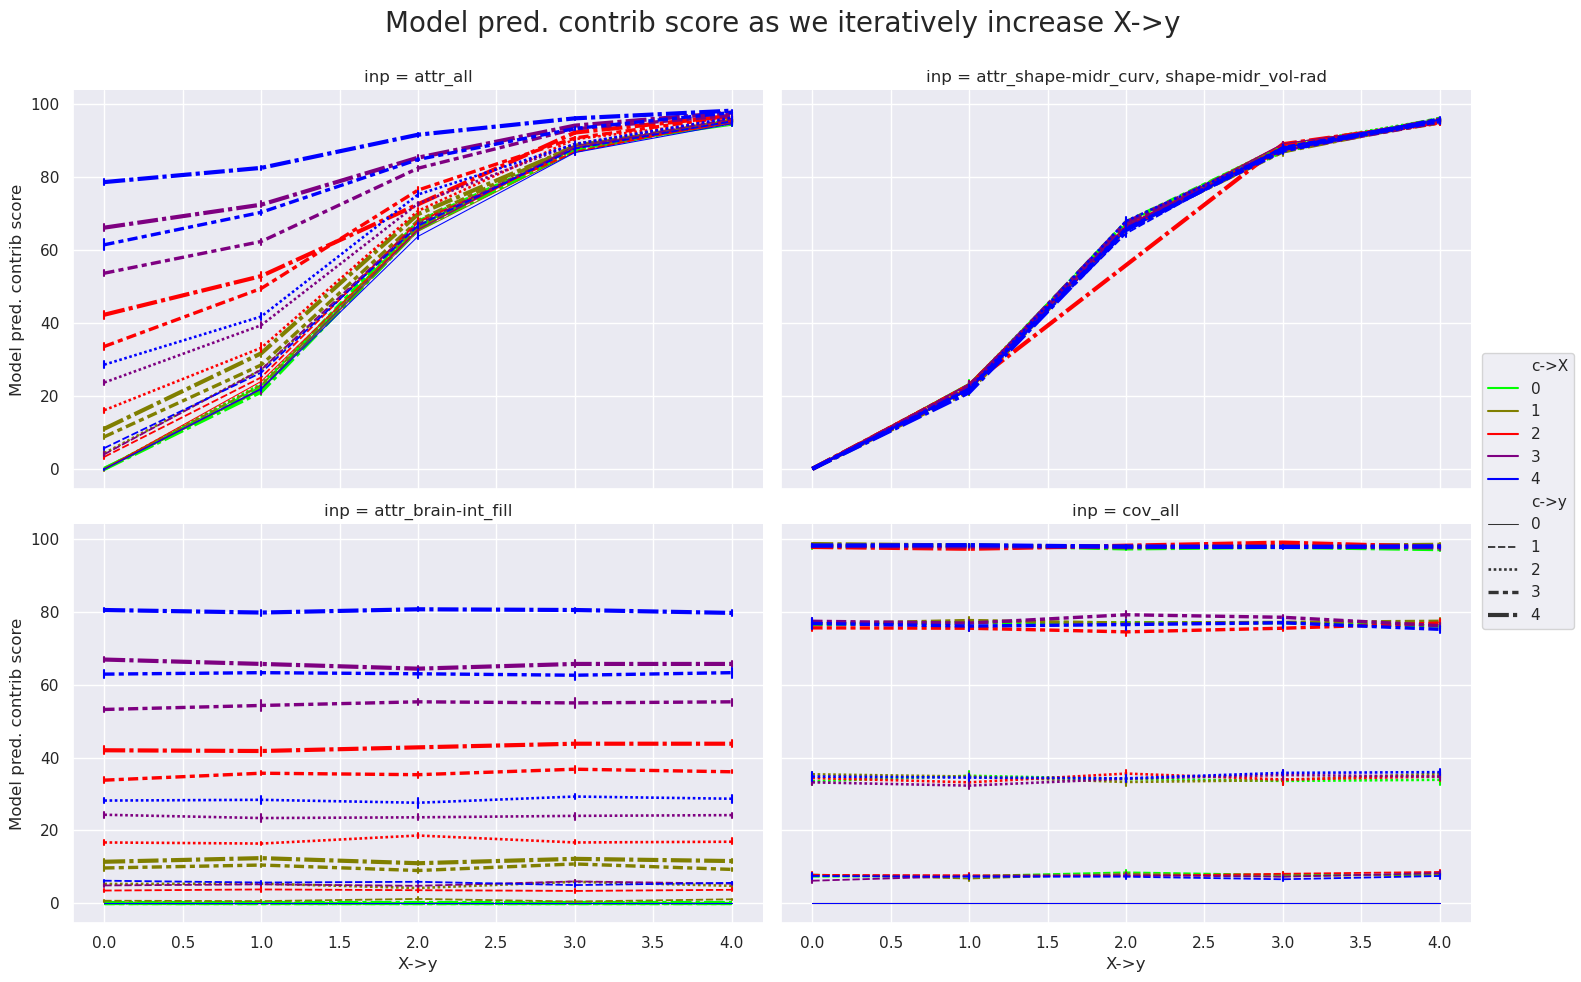

In [54]:
df = show_contrib_table(
                   bl_results, 
                   avg_over_trials=False,
                   filter_rows={'out':['lbl_lesion']}, 
                   filter_cols=['test_metric'])

viz_contrib_table(df, X_axes=['c->y','X->y'])

In [59]:
# look at the SHAP values
df_shap = show_contrib_table(
                   bl_results, 
                   avg_over_trials=True,
                   filter_rows={'inp':['attr_all']}, 
                   filter_cols=['test_metric', 
                                'shap__shape-midr_curv','shap__shape-midr_vol-rad', 
                                'shap__brain-int_fill'])
# df_shap

All results are shown in percentage (%)


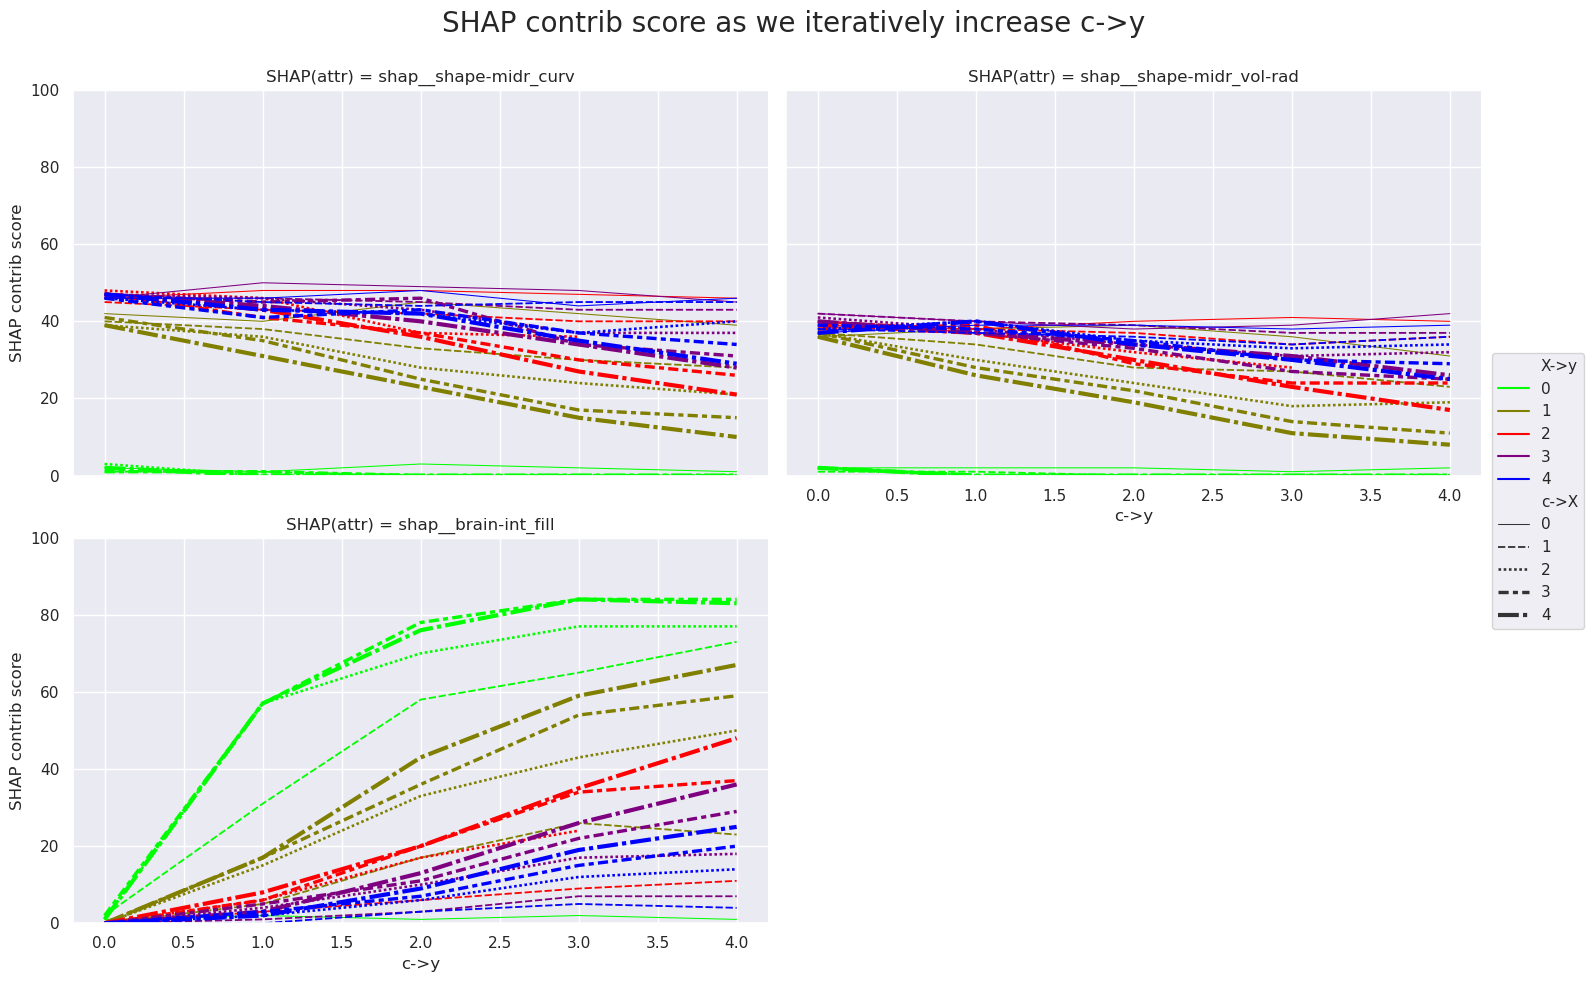

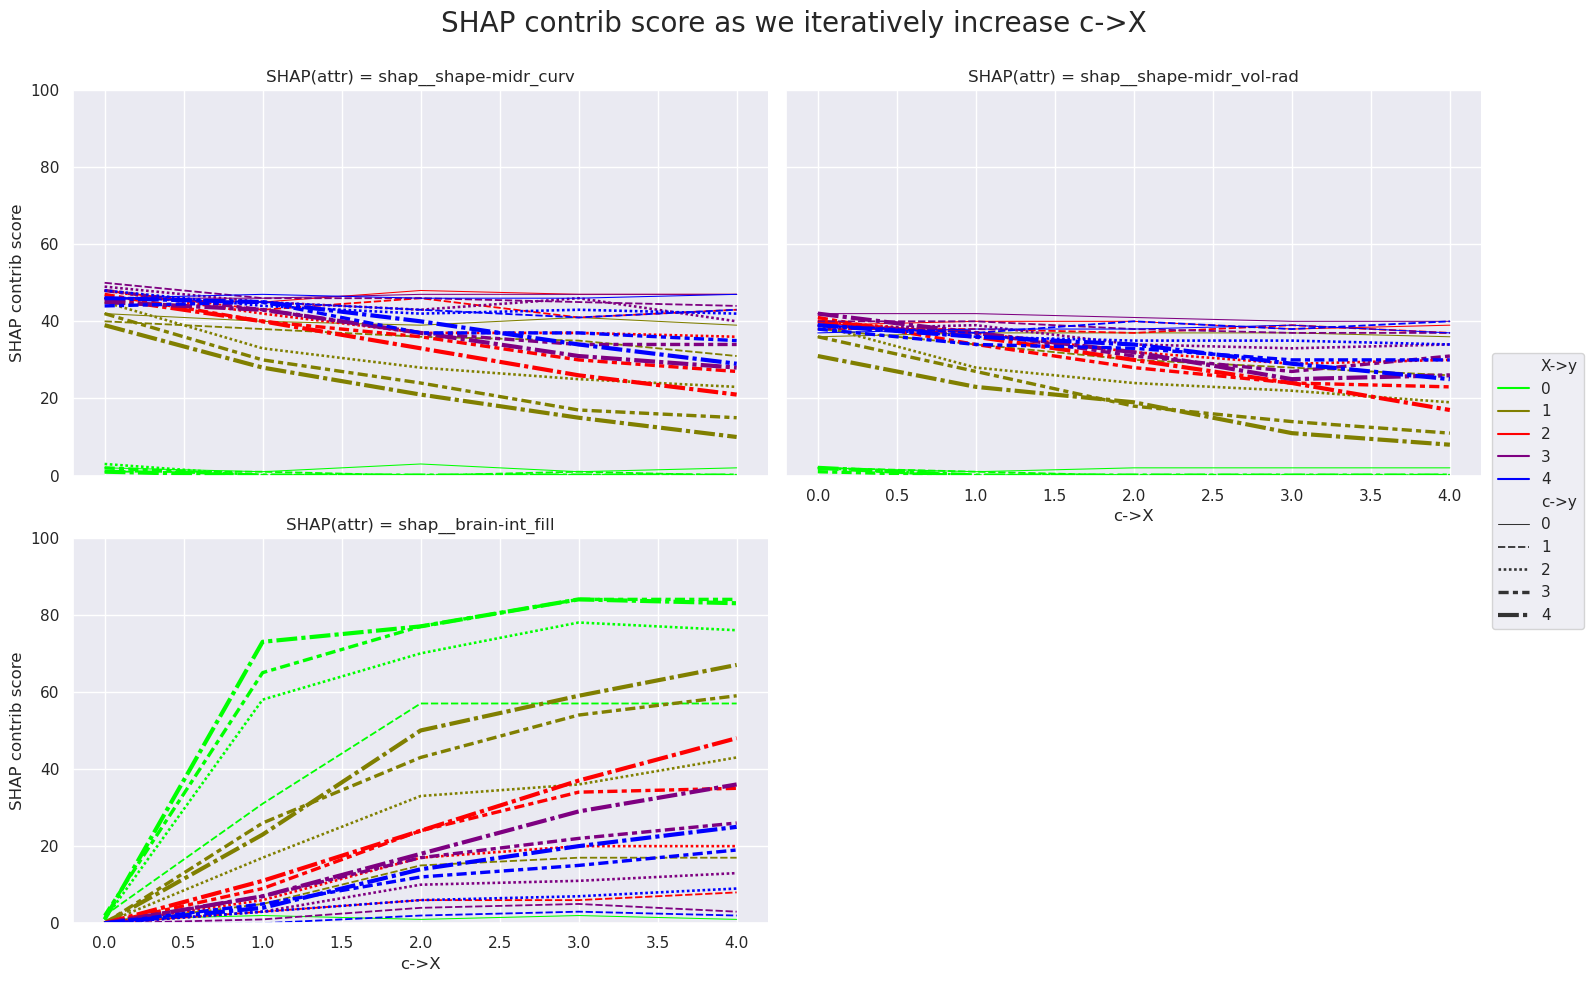

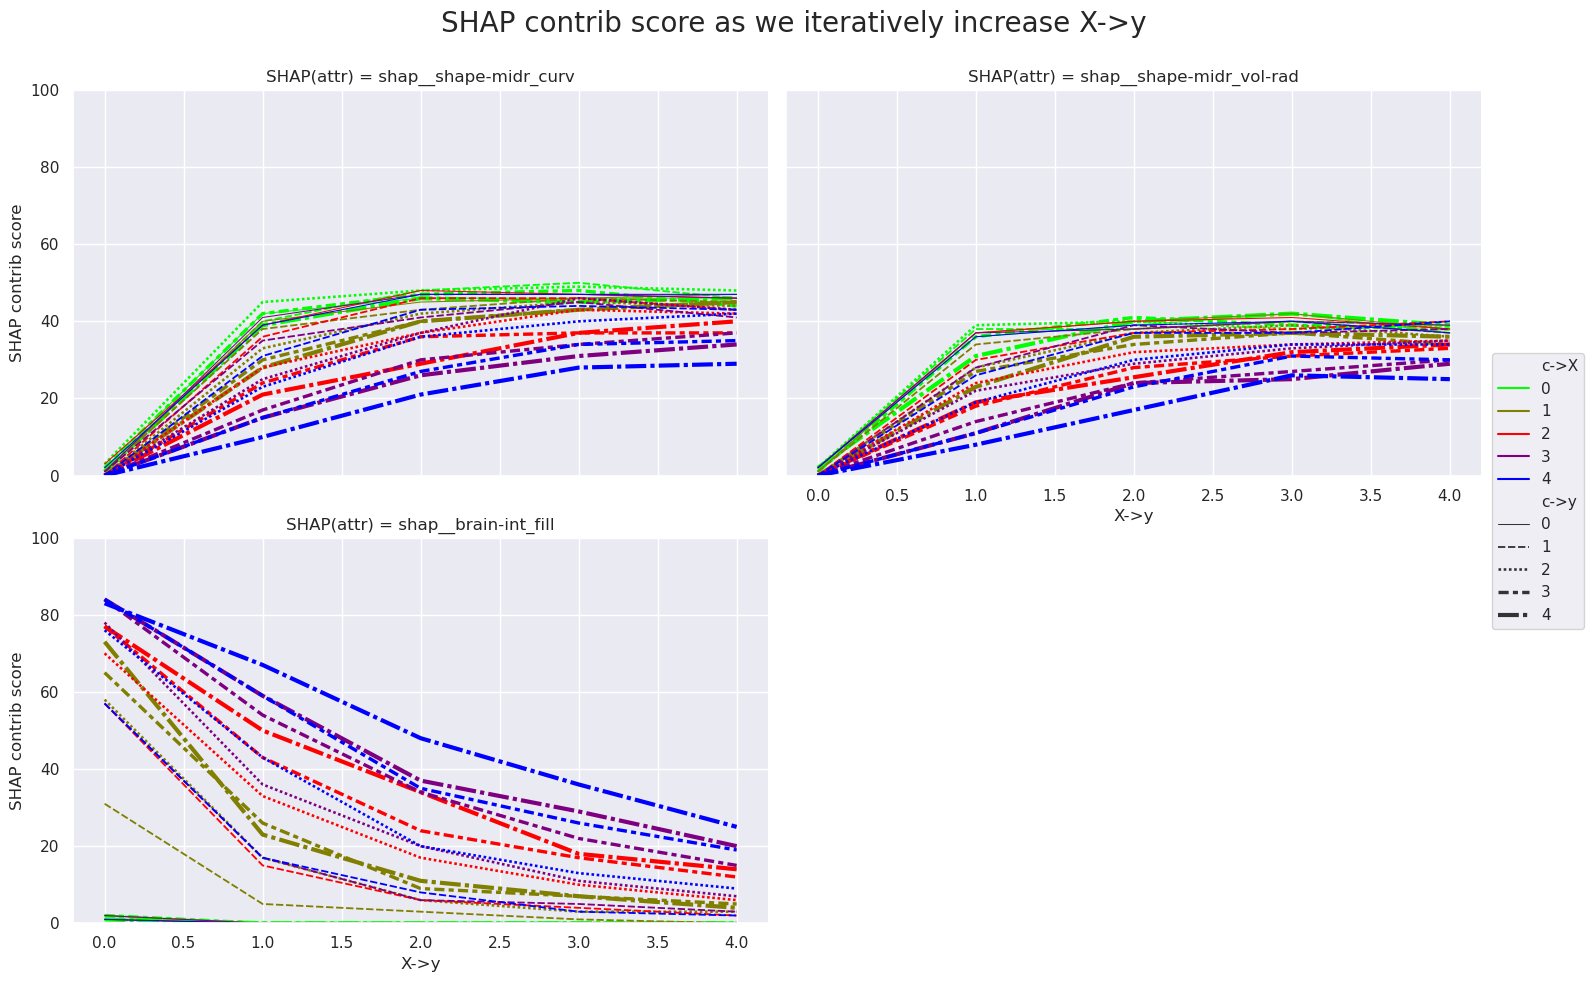

In [61]:
viz_contrib_table(df_shap, X_axes=['c->y','X->y',], show_SHAP=True)